## Importar dataframes

In [1]:
import pandas as pd

ies = ['Una', 'UniBH', 'Unisociesc', 'USJT', 'Ânima']

list = []

for ies in ies:
    base = pd.read_excel('Downloads/RA %s.xlsx' % ies, skiprows = 3).iloc[:, :-1]
    column = ['Empresa']
    [column.append(col) for col in base.columns.tolist()]
    base['Empresa'] = [ies for i in range(len(base))]
    base = base[column]
    list.append(base)
    
base = pd.concat(list)
display(base.head(5).sort_index())

,Empresa,Id HugMe,Origem,Id Origem,Data Reclamação,Status Hugme,Status RA,Arquivado ?,Congelado?,Título,...,Moderação usuário que solicitou,Moderação data da resposta,Tipo Hugme,Data fechamento,Quantidade interações consumidor,Quantidade interações empresa,Feed tipo,Fonte informação tipo,Histórico,Canal
0,Una,28609971,ReclameAQUI,96557163,2019-10-30 08:54:12,Novo,Não respondido,Não,Não,Falta de acesso ao U Life,...,NaN,NaT,NaN,NaT,1,0,NaN,RA Reclamação,action: INTERACAO\ndata: 30/10/2019 08:54:54\n...,NaN
1,Una,28600751,ReclameAQUI,96537423,2019-10-29 15:51:26,Respondido,Respondido,Não,Não,Renovação online de livros,...,NaN,NaT,NaN,NaT,1,1,NaN,RA Reclamação,action: INTERACAO\ndata: 29/10/2019 15:52:58\n...,NaN
2,Una,28599629,ReclameAQUI,96535013,2019-10-29 15:00:25,Novo,Não respondido,Não,Não,Não tenho acesso ao portal do aluno Ulife,...,NaN,NaT,NaN,NaT,1,0,NaN,RA Reclamação,action: INTERACAO\ndata: 29/10/2019 15:01:00\n...,NaN
3,Una,28591130,ReclameAQUI,96521363,2019-10-29 10:19:51,Respondido,Respondido,Não,Não,Portal dos alunos fora do ar,...,NaN,NaT,NaN,NaT,1,1,NaN,RA Reclamação,action: INTERACAO\ndata: 29/10/2019 10:21:06\n...,NaN
4,Una,28582802,ReclameAQUI,96503363,2019-10-28 17:58:49,Respondido,Respondido,Não,Não,"Área do Aluno só vive fora do ar, prejudicando...",...,NaN,NaT,NaN,NaT,1,1,NaN,RA Reclamação,action: INTERACAO\ndata: 28/10/2019 17:58:54\n...,NaN


## Criar dataframe de indicadores

In [2]:
from datetime import timedelta
import numpy as np

columns = ['Empresa', 'Id HugMe', 'Data Reclamação', 'Status RA', 'Voltaria a fazer negócio?', 'Nota']
data = lambda d: base[(base['Data Reclamação'] > (d - timedelta(days = 180))) & (base['Data Reclamação'] <= d)][columns]
date = [base['Data Reclamação'].max().date() - timedelta(days = i) for i in range((base['Data Reclamação'].max().date() - base['Data Reclamação'].min().date() - timedelta(days = 180)).days)]

nota = lambda data_d: data_d['Nota'].tolist()

ava_res = lambda row: 1 if row == 'Avaliado Resolvido' else (0 if row == 'Avaliado Não Resolvido' else np.nan)
ind_sol = lambda data_d: [ava_res(row) for row in data_d['Status RA']]

vol_neg = lambda row: 1 if row == 'Sim' else (0 if row == 'Não' else np.nan)
neg_nov = lambda data_d: [vol_neg(row) for row in data_d['Voltaria a fazer negócio?']]

ava_ra = lambda data_d: 1 * 2 + np.nanmean(nota(data_d)) / 10 * 3 + np.nanmean(ind_sol(data_d)) * 3 + np.nanmean(neg_nov(data_d)) * 2

df_ind = pd.DataFrame([[empresa, d, round(np.nanmean(nota(data(d)[data(d)['Empresa'] == empresa])), 3), round(np.nanmean(ind_sol(data(d)[data(d)['Empresa'] == empresa])), 3), round(np.nanmean(neg_nov(data(d)[data(d)['Empresa'] == empresa])), 3), round(ava_ra(data(d)[data(d)['Empresa'] == empresa]), 3)] for empresa in np.unique(base.Empresa) for d in date], columns = ['Empresa', 'Data Reclamação', 'Nota', 'Índice de Solução', 'Voltaria a fazer negócio', 'Avaliação Reclame Aqui'])

display(df_ind.head(5))

/Users/igorjuliopimenta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """


,Empresa,Data Reclamação,Nota,Índice de Solução,Voltaria a fazer negócio,Avaliação Reclame Aqui
0,USJT,2019-10-30,5.410,0.786,0.556,7.093
1,USJT,2019-10-29,5.364,0.780,0.551,7.050
2,USJT,2019-10-28,5.370,0.782,0.546,7.048
3,USJT,2019-10-27,5.370,0.782,0.546,7.048
4,USJT,2019-10-26,5.370,0.782,0.546,7.048


## Criar estrutura hierárquica de tags

In [3]:
base = base.replace(to_replace = 'Matricula/Rematrícula', value = 'Matrícula/Rematrícula')
base = base.replace(to_replace = 'Núcle de Conclusão Acadêmica ', value = 'Núcleo de Conclusão Acadêmica')
base['Fies'] = base['Fies'].replace(to_replace = 'Restituição', value = 'Restituição Fies')
base['Pravaler'] = base['Pravaler'].replace(to_replace = 'Restituição', value = 'Restituição Pravaler')
base['Pravaler'] = base['Pravaler'].replace(to_replace = 'Renovação', value = 'Renovação Pravaler')
base['Prouni'] = base['Prouni'].replace(to_replace = 'Renovação', value = 'Renovação Prouni')

tag_columns = base.iloc[:, base.columns.tolist().index('Tags') + 1 : base.columns.tolist().index('Resposta da empresa') - 1].columns.tolist()

tag_category = ['Assuntos Gerais', 'Financeiro', 'Financiamentos', 'Acadêmico']
tag_dict = dict((category, {}) for category in tag_category if category != 'Assuntos Gerais')
tag_dict['Assuntos Gerais'] = [tag.strip() for tag in np.unique([item for row in [tag.split(' ; ') for tag in base['Assuntos Gerais'].tolist() if type(tag) == str] for item in row])]

[tag_dict[category].update({subcategory.strip(): [tag.strip() for tag in np.unique([item for row in [tag.split(' ; ') for tag in base[subcategory.strip()].tolist() if type(tag) == str] for item in row])]}) for category in filter(lambda item: item != 'Assuntos Gerais', tag_category) if category in tag_columns for subcategory in np.unique([item for row in [tag.split(' ; ') for tag in base[category].tolist() if type(tag) == str] for item in row])]

display(tag_dict)

{'Financeiro': {'Acordo': ['Acordo realizado', 'Consulta de débitos'],
  'Boleto': ['Baixa não efetuada',
   'Cobrança de Crédito/DP',
   'Dúvidas sobre boleto ou cobrança',
   'Indisponível ou não recebido',
   'Reabertura de pagamento em Boleto para correção de valores',
   'Restituição de Valores',
   'Revisão de boleto'],
  'Bolsas': ['Descontos', 'Mérito Enem'],
  'Inadimplência': ['Empresa de cobrança']},
 'Financiamentos': {'Fies': ['Lançamento financiamento',
   'Aditamento',
   'Restituição Fies',
   'Suspensão'],
  'Pravaler': ['Contratação', 'Renovação Pravaler', 'Restituição Pravaler'],
  'Prouni': ['Renovação Prouni']},
 'Acadêmico': {'Assuntos Gerais': ['Informações Biblioteca',
   'Parcerias - Informações convênios com empresas',
   'Reclamação sobre Infraestrutura'],
  'COI': ['Disciplina Isolada'],
  'Colação de Grau': ['Datas', 'Especial'],
  'Coordenador': ['Agendamento reunião com o coordenador',
   'Dúvidas Geral',
   'Matricula em disciplinas equivalentes',
   'No

## Criar dataframe de tags

In [4]:
import numpy as np

df_tags = pd.DataFrame([[id, base[base['Id HugMe'] == id]['Data Reclamação'].tolist()[0], base[base['Id HugMe'] == id]['Empresa'].tolist()[0], item.strip()] for id in base['Id HugMe'] for row in [tag.split(' ; ') for tag in base[base['Id HugMe'] == id].Tags.tolist() if type(tag) == str] for item in row], columns = ['Id HugMe', 'Data Reclamação', 'Empresa', 'Tag'])

display(df_tags.head(5))

,Id HugMe,Data Reclamação,Empresa,Tag
0,28570673,2019-10-28 08:36:55,Una,Fies
1,28570673,2019-10-28 08:36:55,Una,Aditamento
2,28555389,2019-10-26 08:08:36,Una,Boleto
3,28555389,2019-10-26 08:08:36,Una,Revisão de boleto
4,28520538,2019-10-24 11:09:33,Una,Acordo


## Criar novas colunas no dataframe de tags

In [5]:
df_tags.insert(3, 'Categoria', 0)
df_tags.insert(4, 'Subcategoria', 0)

## Incluir categoria e subcategoria no dataframe de tags

In [6]:
def sub_tag(category, subcategory, tag):
    df_tags['Categoria'][df_tags.Tag == tag] = category
    df_tags['Subcategoria'][df_tags.Tag == tag] = subcategory
    
[sub_tag(category, subcategory, tag) for category in tag_dict.keys() if category != 'Assuntos Gerais' for subcategory in tag_dict[category].keys() for tag in tag_dict[category][subcategory]]
[sub_tag(category, category, tag) for category in tag_dict.keys() if category == 'Assuntos Gerais' for tag in tag_dict[category]]

df_tags.drop(df_tags[df_tags['Categoria'] == 0].index, inplace = True)

df_tags = df_tags.reset_index(drop=True)

display(df_tags.head(5))

/Users/igorjuliopimenta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/igorjuliopimenta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/igorjuliopimenta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ig

,Id HugMe,Data Reclamação,Empresa,Categoria,Subcategoria,Tag
0,28570673,2019-10-28 08:36:55,Una,Financiamentos,Fies,Aditamento
1,28555389,2019-10-26 08:08:36,Una,Financeiro,Boleto,Revisão de boleto
2,28520538,2019-10-24 11:09:33,Una,Financeiro,Acordo,Acordo realizado
3,28497255,2019-10-23 08:23:40,Una,Acadêmico,Núcleo de Conclusão Acadêmica,Certificado de conclusão de curso
4,28429881,2019-10-18 12:48:10,Una,Acadêmico,Coordenador,Dúvidas Geral


## Plotar word cloud



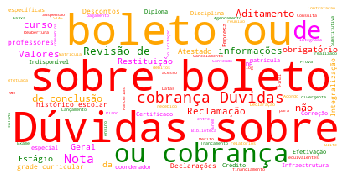

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

mapa_cores = ListedColormap(['orange', 'green', 'red', 'magenta'])

wordcloud = WordCloud(background_color = 'white',
                      colormap = mapa_cores,
                      max_words = 100)

wordcloud.generate(' '.join(df_tags.Tag.tolist()))
%matplotlib inline
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Configurar spreadsheet

In [8]:
from oauth2client.service_account import ServiceAccountCredentials
import gspread

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('Documents/BLiP to G-Sheets.json', scope)
gc = gspread.authorize(credentials)

## Abrir spreadsheet

In [9]:
ws = gc.open_by_key('1BtFgYqVlgy5mDRpdyi62J0D4CfFBgsbOAnQUDspflSE')

## Limpar worksheet

In [10]:
ws.worksheet('Sheet1').resize(rows = 1)
ws.worksheet('Sheet2').resize(rows = 1)
ws.worksheet('Sheet3').resize(rows = 1)

{'spreadsheetId': '1BtFgYqVlgy5mDRpdyi62J0D4CfFBgsbOAnQUDspflSE',
 'replies': [{}]}

## Instalar pacote

In [11]:
! pip install gspread_dataframe

## Alimentar worksheet

In [12]:
import gspread_dataframe as gd

gd.set_with_dataframe(ws.worksheet('Sheet1'), base)
gd.set_with_dataframe(ws.worksheet('Sheet2'), df_tags)
gd.set_with_dataframe(ws.worksheet('Sheet3'), df_ind)